## import

In [3]:
## on nuke, we use env `anaconda3` due to `base` being outdated

import os
from tqdm import tqdm
from IPython.display import clear_output

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.svm import LinearSVC # NOTE: current scikit-learn ver: 1.2.2, not newest, beware with doc
    # Similar to SVC with parameter kernel=’linear’, but implemented in terms of liblinear rather than libsvm, 
    # so it has more flexibility in the choice of penalties and loss functions and 
    # should scale better to large numbers of samples.
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
pd.options.mode.chained_assignment = None  # default='warn'


def calc_SNR(df_tidy):
    ## SNR of R1, aka (R2 without adapter, isi=6k)
    tmp = df_tidy[(df_tidy.resp_id == 'R2') & (df_tidy.isi == 6000)].groupby(['cell_id', 'stim2_id']).dfof
    SNR_R1 = (tmp.mean() / tmp.std()).reset_index()

    ## SNR of R2, aka (R2 with adapter, isi=250)
    tmp = df_tidy[(df_tidy.resp_id == 'R2') & (df_tidy.isi == 250)].groupby(['cell_id', 'stim2_id']).dfof
    SNR_R2 = (tmp.mean() / tmp.std()).reset_index()

    ## merge to df
    df_SNR = SNR_R1.merge(SNR_R2, on=['cell_id', 'stim2_id'], suffixes=('_R1', '_R2'))
    df_SNR.columns = ['cell_id', 'stim2_id', 'SNR_R1', 'SNR_R2'] # rename columns
    df_SNR = df_SNR.sort_values(by='SNR_R1', ascending=False)
    return df_SNR


def get_df_svc(df_tidy, iarea='V1', idatesess=0, ncell_keep=15, filter_cell='vis_pval'):
    df_svc = df_tidy[['dfof', 
                    'cell_id', 'resp_id', 'isi', 'stim2_id', 'trial_id',
                    'filter_cell_vis', 'filter_cell_stim', 'filter_cell_vis_pval',
                    'area', 'mouse', 'date', 'sess'
                    ]]

    df_svc['stim2_dist'] = df_svc.stim2_id.apply(lambda x: 22.5*(8-x) if x > 4 else 22.5*x) 
                            # stim2 distance from 0 deg, hard coded for 8 ori. TODO: modify if needed
    df_svc['date_sess'] = df_svc.date + '_' + df_svc.sess
    
    df_svc = df_svc[(df_svc.isi != 750)
                    & (df_svc.filter_cell_vis == True)
                    & (df_svc.resp_id == 'R2') # only decode R2, with or without adapter (differentiate by isi)
                    & (df_svc.area == iarea)
                    ]
    date_sess_now = df_svc.date_sess.unique()[idatesess] # sess id in a specific area
    df_svc = df_svc[df_svc.date_sess == date_sess_now]

    if df_svc.cell_id.nunique() > ncell_keep:
        
        if filter_cell == 'vis_pval':
            vis_pval_thresh = (df_svc.groupby('cell_id').first()
                            .filter_cell_vis_pval.sort_values() # ascending, smaller pval better
                            [ncell_keep]) # nsample (nrep trial) too small, need to reduce nfeature (ncell)
            df_svc = df_svc[df_svc.filter_cell_vis_pval < vis_pval_thresh]
        
        if filter_cell == 'SNR':
            df_SNR = calc_SNR(df_svc)
            model_cell_id = (df_SNR.groupby('cell_id')
                            .SNR_R2.max().reset_index() # TODO: check if max SNR R2 is the best
                            .sort_values('SNR_R2', ascending=False)
                            .head(ncell_keep).cell_id.values
                            )
            df_svc = df_svc[df_svc.cell_id.isin(model_cell_id)]
            assert set(df_svc.cell_id.unique()) == set(sorted(model_cell_id))
        
    return df_svc


def df_to_train_test(df):
    # input: filtered df_svc
    # output: X_train, X_test, y_train, y_test (of the filter condition)
    
    label_arr = df.groupby('trial_id').stim2_dist.first().values
    label_arr = (label_arr == 90) # 1 = 90 deg, 0 = other ori
    
    feature_mat = (df
                   .pivot_table(index=['trial_id'], columns='cell_id', values='dfof')
                   .fillna(0).to_numpy())
    
    assert feature_mat.shape[0] == label_arr.shape[0]
    # print(label_arr.shape) # ntrial
    # print(feature_mat.shape) # ntrial x ncell
    
    X_train, X_test, y_train, y_test = train_test_split(
        feature_mat, label_arr, test_size=int(1), # 1 trial for test. do not differentiate val/test now
        random_state=0, shuffle=True) 
    # print(X_train.shape, y_train.shape, X_test.shape, y_test.shape) # ntrial x ncell
    
    return X_train, X_test, y_train, y_test

## df_tidy load

In [5]:
dir_inter = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
fig_dir = r'C:\Users\lan\Documents\repos\inter\results\decorrelation vs adp\ref=self before adp'.replace('\\', os.sep)
dir_file = os.path.join(dir_inter, 'adp_dataset_master.xlsx')
data_info = pd.read_excel(dir_file)
data_info.head()

meta = data_info[(data_info.paradigm == 'grating') 
                 & (data_info.area == 'LM')
                 & ((data_info.cellpose_seg == True) | (data_info.manual_seg == True))] # ensure segmentation
meta = meta.reset_index(drop=True)
nset = meta.shape[0]
print(meta.area.value_counts(), nset)
meta_LM = meta.copy()

meta = data_info[(data_info.paradigm == 'grating') 
                 & (data_info.area == 'V1') 
                 & (data_info.gcamp == '6s') # avoid mixing in gcamp8f
                 & ((data_info.cellpose_seg == True) | (data_info.manual_seg == True))] # there are 2 data in V1 that haven't been segmented due to cellpose failing with low quality tiff
meta = meta.reset_index(drop=True)
nset = meta.shape[0]
print(meta.area.value_counts(), nset)
meta_V1 = meta.copy()

meta = data_info[(data_info.paradigm == 'grating') 
                 & (data_info.area == 'LI') 
                 & (data_info.gcamp == '6s') # avoid mixing in gcamp8f
                 & (data_info.manual_seg != 'TODO') # 2 LI data still need manual segm
                 & (data_info.note.str.contains('bad') != True) # exclude bad data
                 ]
meta = meta.reset_index(drop=True)
nset = meta.shape[0]
print(meta.area.value_counts(), nset)
meta_LI = meta.copy()

meta = pd.concat([meta_V1, meta_LM, meta_LI], axis=0).reset_index(drop=True)
# meta

LM    22
Name: area, dtype: int64 22
V1    6
Name: area, dtype: int64 6
LI    18
Name: area, dtype: int64 18


In [6]:
nset = len(meta)
df_tidy = pd.DataFrame()

for iset in tqdm(range(nset)):
    # print(f'iset={iset}, nset={nset}')

    mouse = meta.loc[iset, 'mouse'].astype(str)
    imouse = 'i' + mouse
    date = meta.loc[iset, 'date'].astype(str)
    area = meta.loc[iset, 'area']
    # sess = '00' + meta.loc[iset, 'num'].astype(str)
    sess = meta.loc[iset, 'num']
    # print(imouse, date, area, sess)
    dir_identifier = f'{area}_{imouse}_{date}_{sess}'

    dir_data = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
    csv_filename = 'df_tidy_continuous_vis_pval.csv'
    try:
        df_tidy_now = pd.read_csv(os.path.join(dir_data, dir_identifier, csv_filename))
    except:
        dir_identifier = dir_identifier + '_cellpose'
        df_tidy_now = pd.read_csv(os.path.join(dir_data, dir_identifier, csv_filename))

    df_tidy_now['mouse'] = mouse
    df_tidy_now['date'] = date
    df_tidy_now['sess'] = sess
    df_tidy_now['cell_id'] = (df_tidy_now.date.astype(str) + '_' 
                               + df_tidy_now.sess.astype(str) + '_' 
                               + df_tidy_now.cell_id.astype(str)) # cell_id adjusted to be unique across mice, dates, sessions
    df_tidy = pd.concat([df_tidy, df_tidy_now], axis=0).reset_index(drop=True)
    # break
    
clear_output()

# print(df_tidy.mouse.unique(), 
#       df_tidy.date.unique(), 
#       df_tidy.sess.unique(), 
#       df_tidy.area.unique(), 
#       df_tidy.isi.unique(), 
#       df_tidy.stim1_contrast.unique(), 
#       df_tidy.stim2_id.unique(), 
#       df_tidy.resp_id.unique())
# df_tidy.sample(5, random_state=0)

# goal: decode 90 vs another ori

## feature selection
reduce ncell in model to prevent overfit

### validate diversity of tuning 
neuron in model should have diff tuning curves

In [9]:
ncell_keep = 15
df_svc = get_df_svc(df_tidy, iarea='V1', idatesess=0, ncell_keep=ncell_keep, filter_cell='vis_pval')

,dfof,cell_id,resp_id,isi,stim2_id,trial_id,filter_cell_vis,filter_cell_stim,filter_cell_vis_pval,area,mouse,date,sess,stim2_dist,date_sess
33990,0.009437,200720_003_2,R2,250,2,1,True,True,0.000083,V1,1323,200720,003,45.0,200720_003
33991,0.169678,200720_003_2,R2,250,2,2,True,True,0.000083,V1,1323,200720,003,45.0,200720_003
33993,-0.006076,200720_003_2,R2,6000,2,4,True,True,0.000083,V1,1323,200720,003,45.0,200720_003
33995,0.028049,200720_003_2,R2,250,7,6,True,False,0.000083,V1,1323,200720,003,22.5,200720_003
33997,0.249162,200720_003_2,R2,250,4,8,True,False,0.000083,V1,1323,200720,003,90.0,200720_003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77501,0.045068,200720_003_95,R2,250,3,453,True,True,0.003038,V1,1323,200720,003,67.5,200720_003
77502,0.066632,200720_003_95,R2,250,3,454,True,True,0.003038,V1,1323,200720,003,67.5,200720_003
77504,-0.029060,200720_003_95,R2,6000,6,456,True,False,0.003038,V1,1323,200720,003,45.0,200720_003
77508,-0.001724,200720_003_95,R2,250,1,460,True,True,0.003038,V1,1323,200720,003,22.5,200720_003


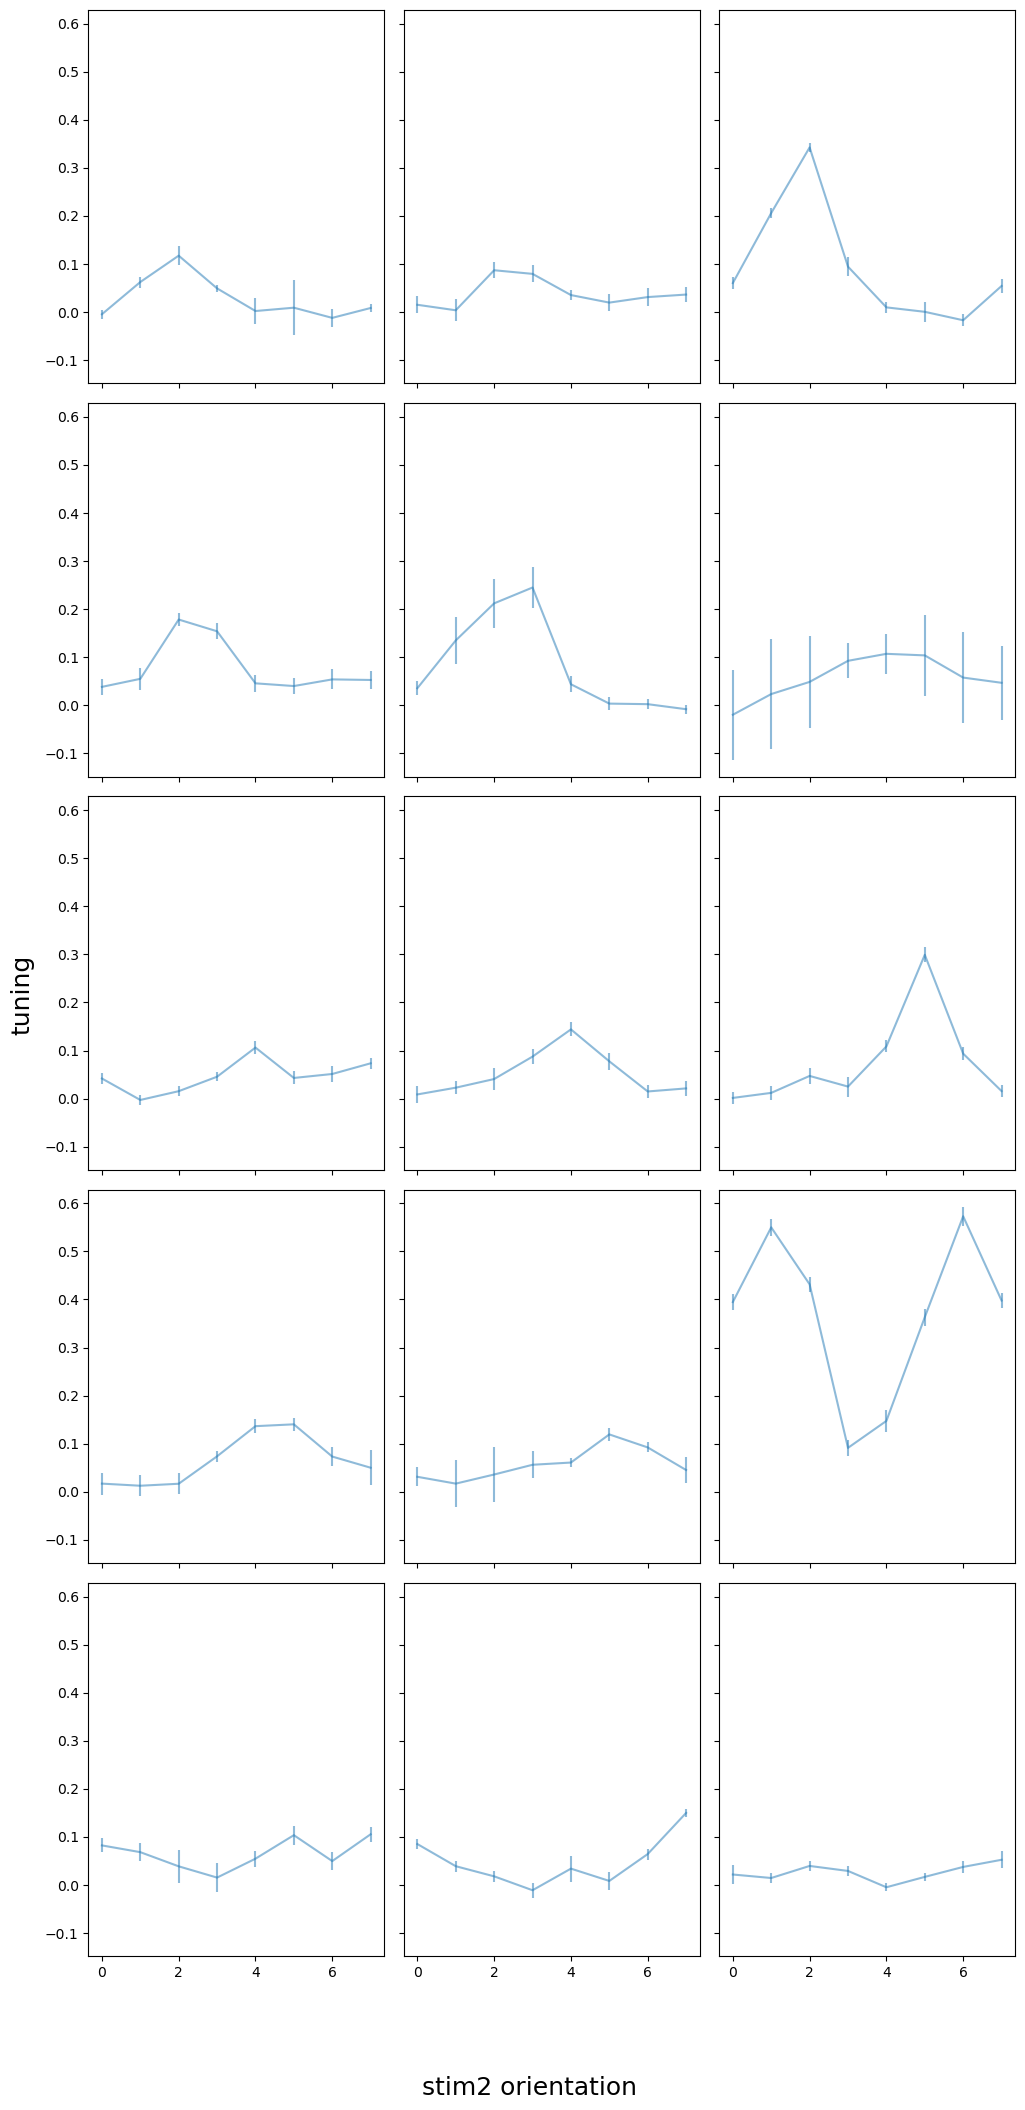

In [14]:
model_cell_resp = df_svc.groupby(['cell_id', 'stim2_id']).dfof.mean().reset_index()
model_cell_sem = df_svc.groupby(['cell_id', 'stim2_id']).dfof.sem().reset_index()

tuning_pop = []
tuning_pop_sem = []
for icell in df_svc.cell_id.unique():
    tuning_cell = model_cell_resp[model_cell_resp.cell_id==icell].dfof.tolist()
    tuning_cell_sem = model_cell_sem[model_cell_sem.cell_id==icell].dfof.tolist()
    # tuning_cell = (tuning_cell - np.min(tuning_cell)) / (np.max(tuning_cell) - np.min(tuning_cell)) # min-max normalization
    tuning_pop.append(tuning_cell)
    tuning_pop_sem.append(tuning_cell_sem)

tuning_pop = np.array(tuning_pop) # ncell_keep x nori
tuning_pop_sem = np.array(tuning_pop_sem)
tuning_pop = tuning_pop[np.argsort(np.argmax(tuning_pop, axis=1)), :] # sort cells by tuning argmax
tuning_pop_sem = tuning_pop_sem[np.argsort(np.argmax(tuning_pop, axis=1)), :]

nrow = 5
ncol = ncell_keep // nrow
fig, ax = plt.subplots(nrow, ncol, figsize=(10, 20), sharex=True, sharey=True)

for isubplot in np.arange(nrow*ncol): # plot each cell in a subplot
    ax[isubplot//ncol, isubplot%ncol].errorbar(x=np.arange(8), 
                                               y=tuning_pop[isubplot], 
                                               yerr=tuning_pop_sem[isubplot], 
                                               alpha=0.5)
        
fig.text(0.5, -0.05, 'stim2 orientation', ha='center', fontsize=18)
fig.text(-0.02, 0.5, 'tuning', va='center', rotation='vertical', fontsize=18)

fig.tight_layout()
# fig.savefig(dir_fig + 'tuning_of_model_cells_no_norm.pdf', bbox_inches='tight')

## cross val search reg
find optimal reg param C

### aware decoder

two separate models for two isi.  
one model: train and test with isi=6k  
another model: train and test with isi=250  

100%|██████████| 7/7 [00:10<00:00,  1.43s/it]


isi=6k


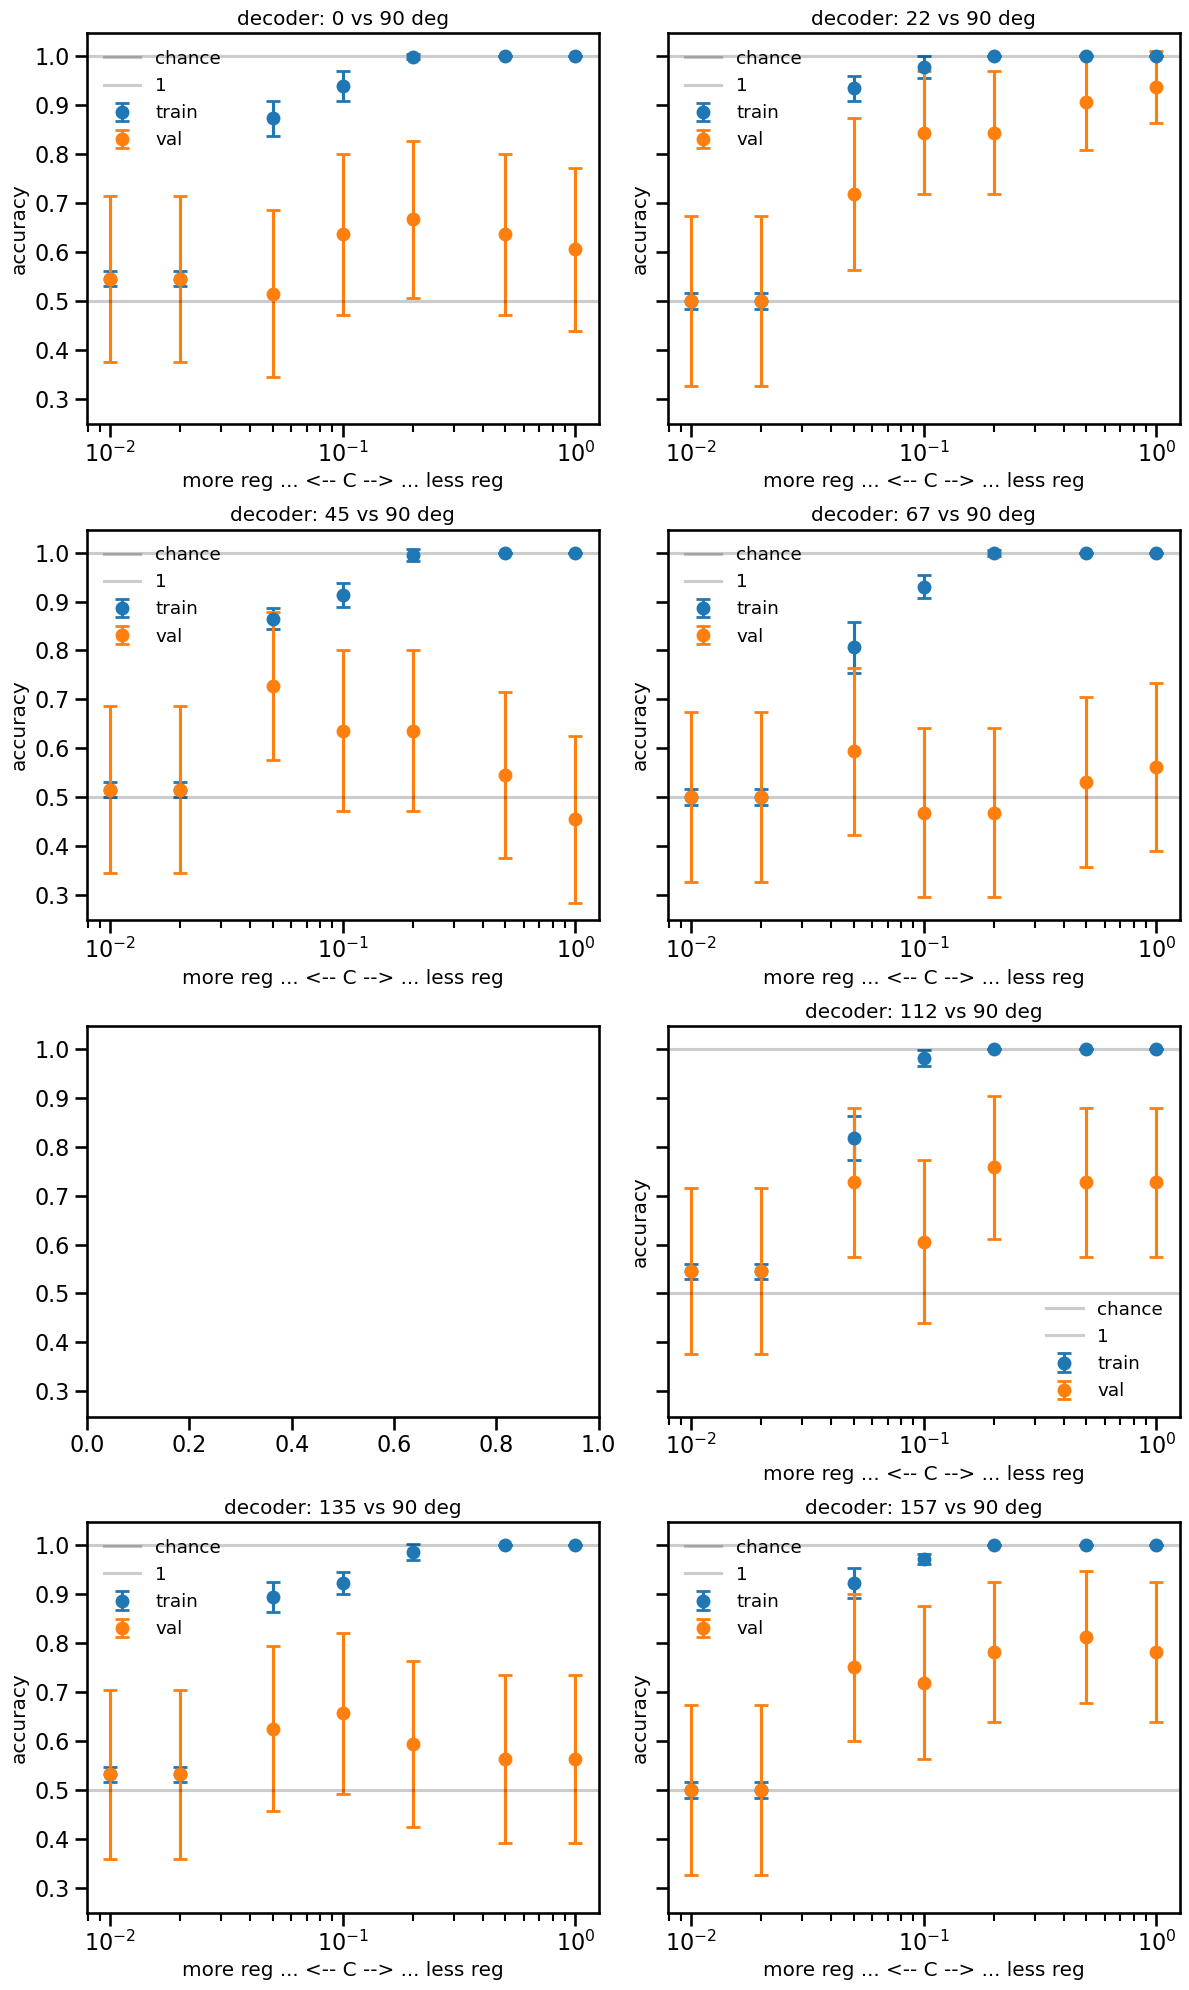

In [ ]:

df_svc = get_df_svc(df_tidy, iarea='V1', idatesess=4, ncell_keep=999)

# use_data = 'isi_both'
# use_data = 'isi=250' # adapted
use_data = 'isi=6k' # unadapted

nrow = 4
ncol = 2
cross_val_method = LeaveOneOut()
fig, ax = plt.subplots(4, 2, figsize=(12, 20), sharey=True)

acc_val_mean_iori = []
acc_val_ci_iori = [] # confidence interval based on binomial distribution
for iori in tqdm(other_ori):
    df_pair = df_svc[((df_svc.stim2_id == 4) | (df_svc.stim2_id == iori))]
    df_pair_250 = df_pair[df_pair.isi == 250]
    df_pair_6000 = df_pair[df_pair.isi == 6000]

    ## split train vs test for each isi
    X_train_250, X_test_250, y_train_250, y_test_250 = df_to_train_test(df_pair_250)
    X_train_6000, X_test_6000, y_train_6000, y_test_6000 = df_to_train_test(df_pair_6000)

    ## stack training data across isi - ntrial per isi mostly balanced (30% vs 35%)
    X_train = np.vstack((X_train_250, X_train_6000))
    y_train = np.hstack((y_train_250, y_train_6000))
    X_test = np.vstack((X_test_250, X_test_6000))
    y_test = np.hstack((y_test_250, y_test_6000))

    ## shuffle trials in the same way
    seed_val = 0
    np.random.seed(seed_val)
    np.random.shuffle(X_train) # shuffled along the first axis, aka trials
    np.random.shuffle(y_train)
    np.random.shuffle(X_test)
    np.random.shuffle(y_test)

    ## cross validation to find optimal C
    acc_train_mean = []
    acc_train_std = []
    acc_val_mean = []
    acc_val_std = []
    acc_val_ci = [] # confidence interval based on binomial distribution
    acc_test = []
    # C_list = [1e-4 * 10**i for i in range(8)] # 1e-4, 1e-3, ..., 1e3, 1e4
    C_list = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1] # zoom in around 0.1
    nfold = 5

    for C_val in C_list:
        clf = make_pipeline(StandardScaler(),
                            LinearSVC(tol=1e-5, max_iter=int(1e6), 
                                    penalty='l1', dual=False, C=C_val))
        
        if use_data == 'isi_both':
            score_val = cross_validate(clf, X_train, y_train, cv=cross_val_method, return_train_score=True) # instead of cv=nfold, we use leave-one-out
            clf.fit(X_train, y_train)
            score_test = clf.score(X_test, y_test)
        elif use_data == 'isi=250':
            score_val = cross_validate(clf, X_train_250, y_train_250, cv=cross_val_method, return_train_score=True)
            clf.fit(X_train_250, y_train_250)
            score_test = clf.score(X_test_250, y_test_250)
        elif use_data == 'isi=6k':
            score_val = cross_validate(clf, X_train_6000, y_train_6000, cv=cross_val_method, return_train_score=True)
            clf.fit(X_train_6000, y_train_6000)
            score_test = clf.score(X_test_6000, y_test_6000)
        
        acc_train_mean.append(np.mean(score_val['train_score']))
        acc_train_std.append(np.std(score_val['train_score']))
        acc_val_mean.append(np.mean(score_val['test_score']))
        acc_val_std.append(np.std(score_val['test_score']))
        ci_low, ci_high = proportion_confint(count=score_val['test_score'].sum(), nobs=len(score_val['test_score']))
        ci_err = (ci_high - ci_low)/2
        acc_val_ci.append(ci_err)
        acc_test.append(score_test)
    acc_val_mean_iori.append(acc_val_mean)
    acc_val_ci_iori.append(acc_val_ci)
        
        
    ax[int(iori/ncol), iori%ncol].errorbar(x=C_list, y=acc_train_mean, 
                yerr=acc_train_std, fmt='o', capsize=5, capthick=2, label='train')
    ax[int(iori/ncol), iori%ncol].errorbar(x=C_list, y=acc_val_mean,
                yerr=acc_val_ci, fmt='o', capsize=5, capthick=2, label='val')
    # ax[int(iori/ncol), iori%ncol].plot(C_list, acc_test, color='r', marker=".", alpha=0.5, label='test')
    ax[int(iori/ncol), iori%ncol].axhline(y=0.5, color='k',alpha=0.2, label='chance')
    ax[int(iori/ncol), iori%ncol].axhline(y=1, color='k',alpha=0.2, label='1')

    # set x axis to log scale
    ax[int(iori/ncol), iori%ncol].set_xscale('log')

    ax[int(iori/ncol), iori%ncol].legend(frameon=False);
    ax[int(iori/ncol), iori%ncol].set_title(f'decoder: {int(22.5*iori)} vs 90 deg');
    ax[int(iori/ncol), iori%ncol].set_xlabel('more reg ... <-- C --> ... less reg');
    ax[int(iori/ncol), iori%ncol].set_ylabel('accuracy');
    
fig.tight_layout()
print(use_data)

dir_fig = r'C:\Users\lan\Documents\repos\inter\results\decoder_grat8/'.replace('\\', '/')
# fig.savefig(dir_fig + f'aware_decoder_L1_{use_data}_all_cell.pdf', bbox_inches='tight')

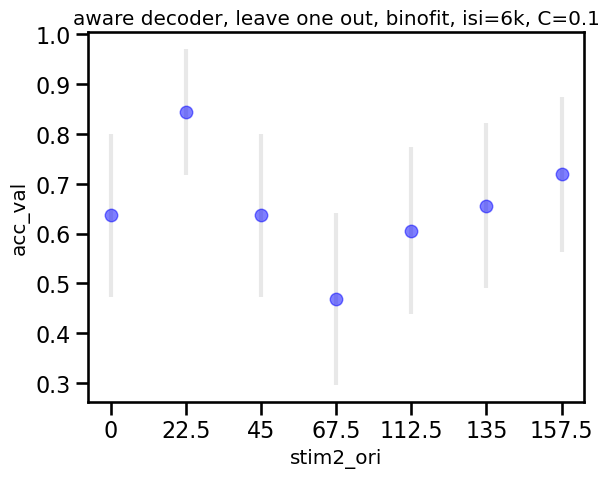

In [ ]:
fix_C = 0.1
# if use_data == 'isi=6k':
    # fix_C = 0.1
# if use_data == 'isi=250':
    # fix_C = 0.2
    
acc_val_C = np.array(acc_val_mean_iori)[:, np.where(np.array(C_list)==fix_C)[0][0]]
acc_val_ci_C = np.array(acc_val_ci_iori)[:, np.where(np.array(C_list)==fix_C)[0][0]]

plt.errorbar(x=np.arange(len(stim2_ori_list)), 
             y=acc_val_C, 
             yerr=acc_val_ci_C, 
             fmt='o', color='b', alpha=0.5, ecolor='lightgray', elinewidth=3, capsize=0);

stim2_ori_list = ['0', '22.5', '45', '67.5', '112.5', '135', '157.5']
plt.xticks(np.arange(len(stim2_ori_list)), stim2_ori_list);
plt.xlabel('stim2_ori')
plt.ylabel(f'acc_val');

title_str = f'aware decoder, leave one out, binofit, {use_data}, C={fix_C}'
plt.title(title_str);
# plt.savefig(dir_fig + f'{title_str}.pdf', bbox_inches='tight')

### naive unaware decoder
train with 6k, test with either - more directly related to decorr, give lower bound of decoding acc

100%|██████████| 7/7 [00:08<00:00,  1.20s/it]


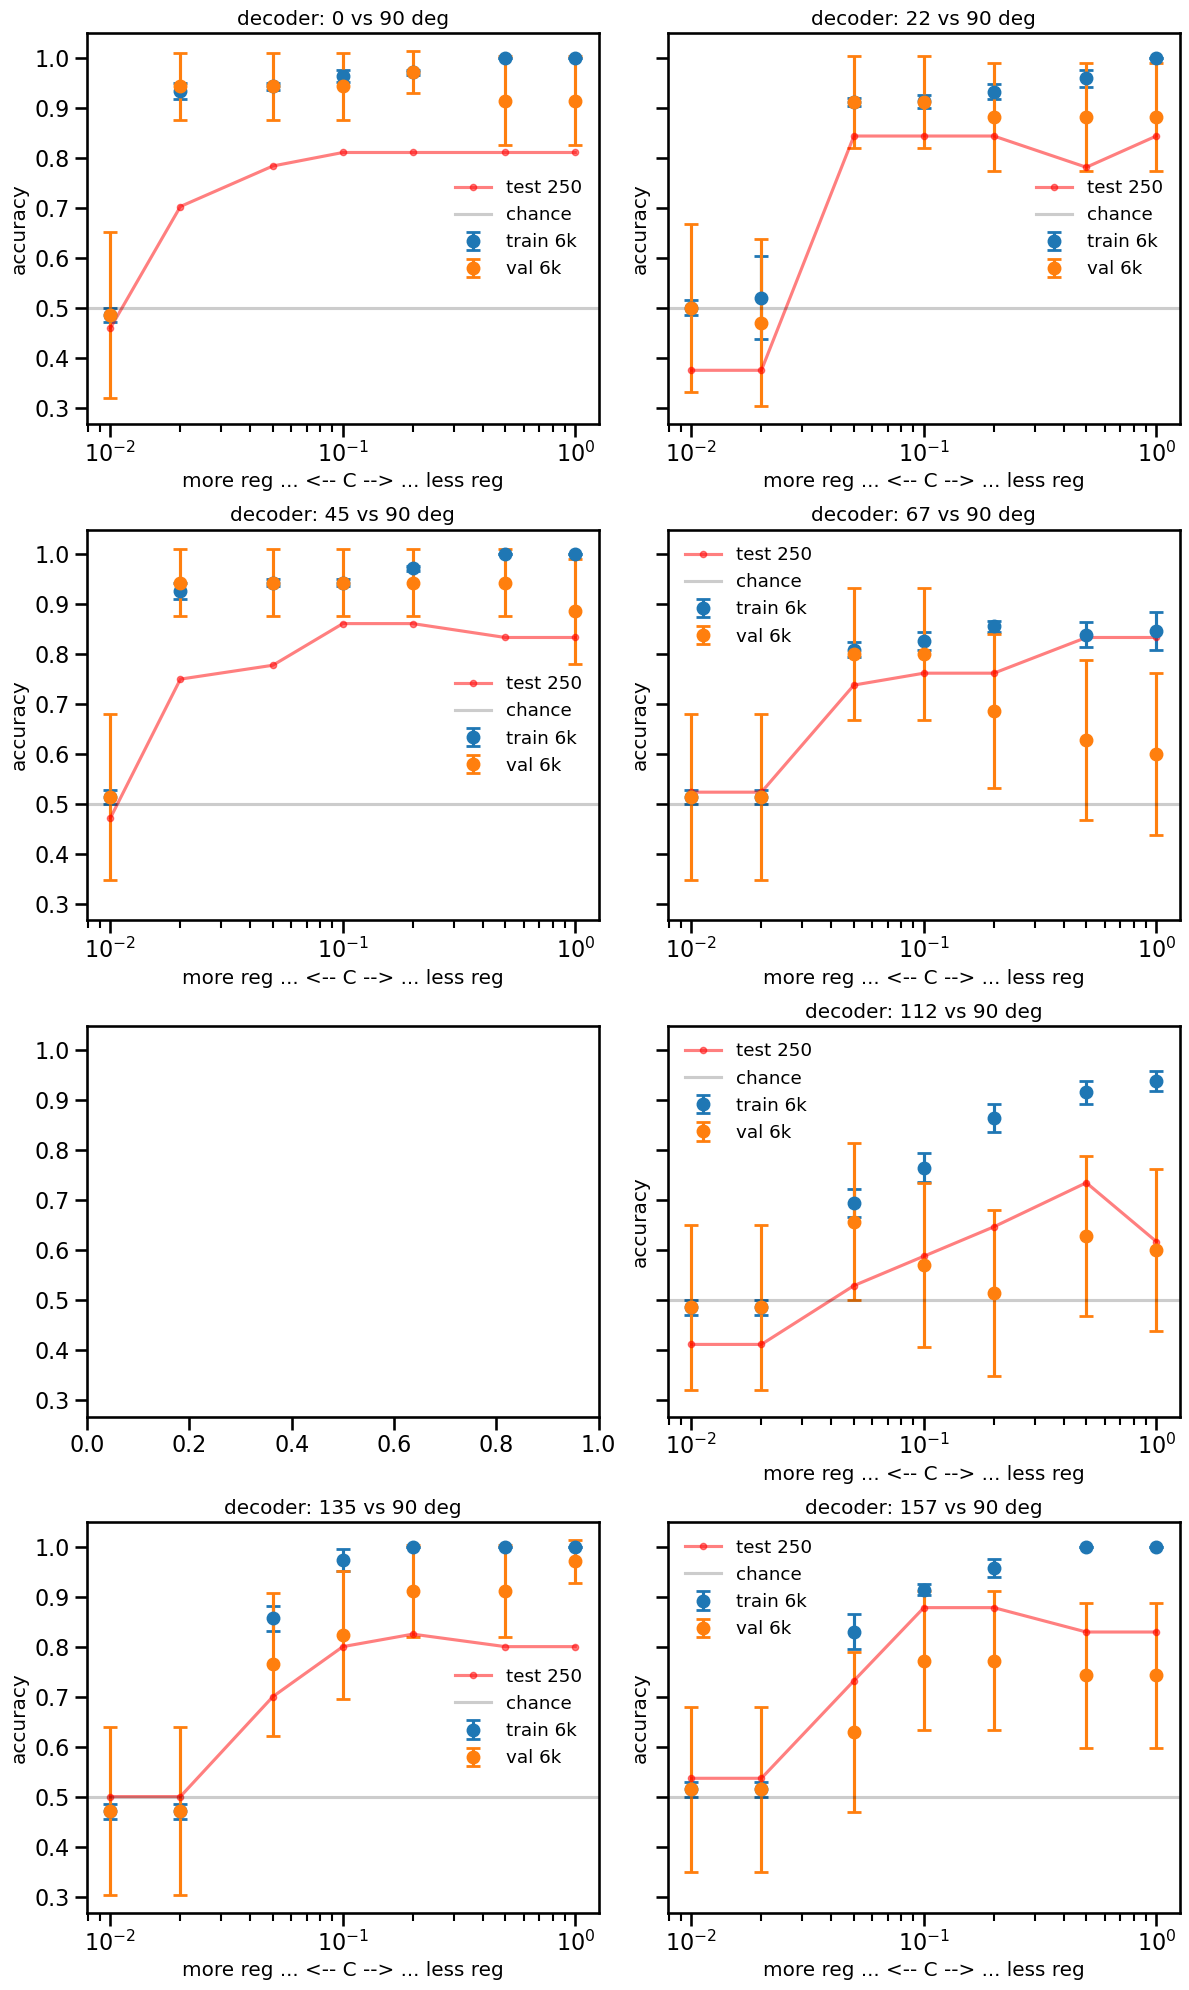

In [ ]:
## find optimal reg param C. 

nrow = 4
ncol = 2
fig, ax = plt.subplots(4, 2, figsize=(12, 20), sharey=True)

acc_val_mean_iori = []
acc_val_ci_iori = [] # confidence interval based on binomial distribution
acc_test_iori = []

for iori in tqdm(other_ori):
    
    ## get data for each pair of ori (another vs 90 deg)
    df_pair = df_svc[((df_svc.stim2_id == 4) | (df_svc.stim2_id == iori))]
    df_pair_250 = df_pair[df_pair.isi == 250]
    df_pair_6000 = df_pair[df_pair.isi == 6000]

    ## split train vs test for each isi
    X_train_250, X_test_250, y_train_250, y_test_250 = df_to_train_test(df_pair_250)
    X_train_6000, X_test_6000, y_train_6000, y_test_6000 = df_to_train_test(df_pair_6000)

    # ## stack training data across isi - ntrial per isi mostly balanced (30% vs 35%)
    # X_train = np.vstack((X_train_250, X_train_6000))
    # y_train = np.hstack((y_train_250, y_train_6000))
    # X_test = np.vstack((X_test_250, X_test_6000))
    # y_test = np.hstack((y_test_250, y_test_6000))

    # ## shuffle trials in the same way
    # seed_val = 0
    # np.random.seed(seed_val)
    # np.random.shuffle(X_train) # shuffled along the first axis, aka trials
    # np.random.shuffle(y_train)
    # np.random.shuffle(X_test)
    # np.random.shuffle(y_test)

    ## cross validation to find optimal C
    acc_train_mean = []
    acc_train_std = []
    acc_val_mean = []
    acc_val_std = []
    acc_val_ci = [] # confidence interval based on binomial distribution
    acc_test = []
    # C_list = [1e-4 * 10**i for i in range(8)] # 1e-4, 1e-3, ..., 1e3, 1e4
    C_list = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1] # zoom in around 0.1
    nfold = 5

    # use_data = 'isi=250' # train with unadapted, test with adapted
    # use_data = 'isi=6k' # train with unadapted, test with unadapted


    for C_val in C_list:
        clf = make_pipeline(StandardScaler(),
                            LinearSVC(tol=1e-5, max_iter=int(1e6), 
                                    penalty='l1', dual=False, C=C_val))

        ## train and val with isi 6k. val is considered as test
        score_val = cross_validate(clf, X_train_6000, y_train_6000, cv=LeaveOneOut(), return_train_score=True)        
        acc_train_mean.append(np.mean(score_val['train_score']))
        acc_train_std.append(np.std(score_val['train_score']))
        
        acc_val_mean.append(np.mean(score_val['test_score']))
        acc_val_std.append(np.std(score_val['test_score']))
        ci_low, ci_high = proportion_confint(count=score_val['test_score'].sum(), nobs=len(score_val['test_score']))
        ci_err = (ci_high - ci_low)/2
        acc_val_ci.append(ci_err)

        ## test with isi 250. train_250 is considered as test (bc model is trained with isi 6k)
        clf.fit(X_train_6000, y_train_6000)
        score_test = clf.score(X_train_250, y_train_250) # test data has only 1 trial. use train as test for isi 250
        acc_test.append(score_test)
        
    acc_val_mean_iori.append(acc_val_mean)
    acc_val_ci_iori.append(acc_val_ci)
    acc_test_iori.append(acc_test)
        
        
    ax[int(iori/ncol), iori%ncol].errorbar(x=C_list, y=acc_train_mean, 
                yerr=acc_train_std, fmt='o', capsize=5, capthick=2, label='train 6k')
    ax[int(iori/ncol), iori%ncol].errorbar(x=C_list, y=acc_val_mean,
                yerr=acc_val_ci, fmt='o', capsize=5, capthick=2, label='val 6k')
    ax[int(iori/ncol), iori%ncol].plot(C_list, acc_test, color='r', marker=".", alpha=0.5, label='test 250')
    ax[int(iori/ncol), iori%ncol].axhline(y=0.5, color='k',alpha=0.2, label='chance')

    # set x axis to log scale
    ax[int(iori/ncol), iori%ncol].set_xscale('log')

    ax[int(iori/ncol), iori%ncol].legend(frameon=False);
    ax[int(iori/ncol), iori%ncol].set_title(f'decoder: {int(22.5*iori)} vs 90 deg');
    ax[int(iori/ncol), iori%ncol].set_xlabel('more reg ... <-- C --> ... less reg');
    ax[int(iori/ncol), iori%ncol].set_ylabel('accuracy');
    
fig.tight_layout()

dir_fig = r'C:\Users\lan\Documents\repos\inter\results\decoder_grat8/'.replace('\\', '/')
fig.savefig(dir_fig + f'decoder_L1_train_val_6k_test_250.pdf', bbox_inches='tight')

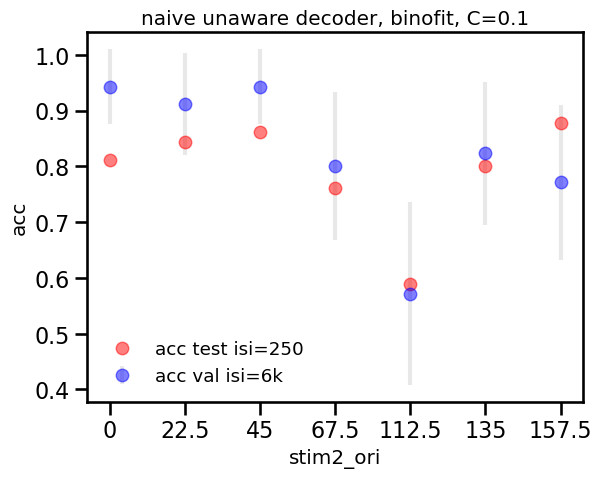

In [ ]:
fix_C = 0.1
# if use_data == 'isi=6k':
    # fix_C = 0.1
# if use_data == 'isi=250':
    # fix_C = 0.2
    
acc_val_C = np.array(acc_val_mean_iori)[:, np.where(np.array(C_list)==fix_C)[0][0]]
acc_val_ci_C = np.array(acc_val_ci_iori)[:, np.where(np.array(C_list)==fix_C)[0][0]]
acc_test_C = np.array(acc_test_iori)[:, np.where(np.array(C_list)==fix_C)[0][0]]

plt.errorbar(x=np.arange(len(stim2_ori_list)), 
             y=acc_val_C, 
             yerr=acc_val_ci_C, 
             label='acc val isi=6k',
             fmt='o', color='b', alpha=0.5, ecolor='lightgray', elinewidth=3, capsize=0);
plt.plot(acc_test_C, 'o', color='r', alpha=0.5, label='acc test isi=250')

stim2_ori_list = ['0', '22.5', '45', '67.5', '112.5', '135', '157.5']
plt.xticks(np.arange(len(stim2_ori_list)), stim2_ori_list);
plt.xlabel('stim2_ori')
plt.ylabel(f'acc');
plt.legend(frameon=False, loc='lower left')

title_str = f'naive unaware decoder, binofit, C={fix_C}'
plt.title(title_str);
plt.savefig(dir_fig + f'{title_str}.pdf', bbox_inches='tight')

### experienced unaware decoder
train with both, test with either - assume decoder learned from visual xp

100%|██████████| 7/7 [00:17<00:00,  2.45s/it]


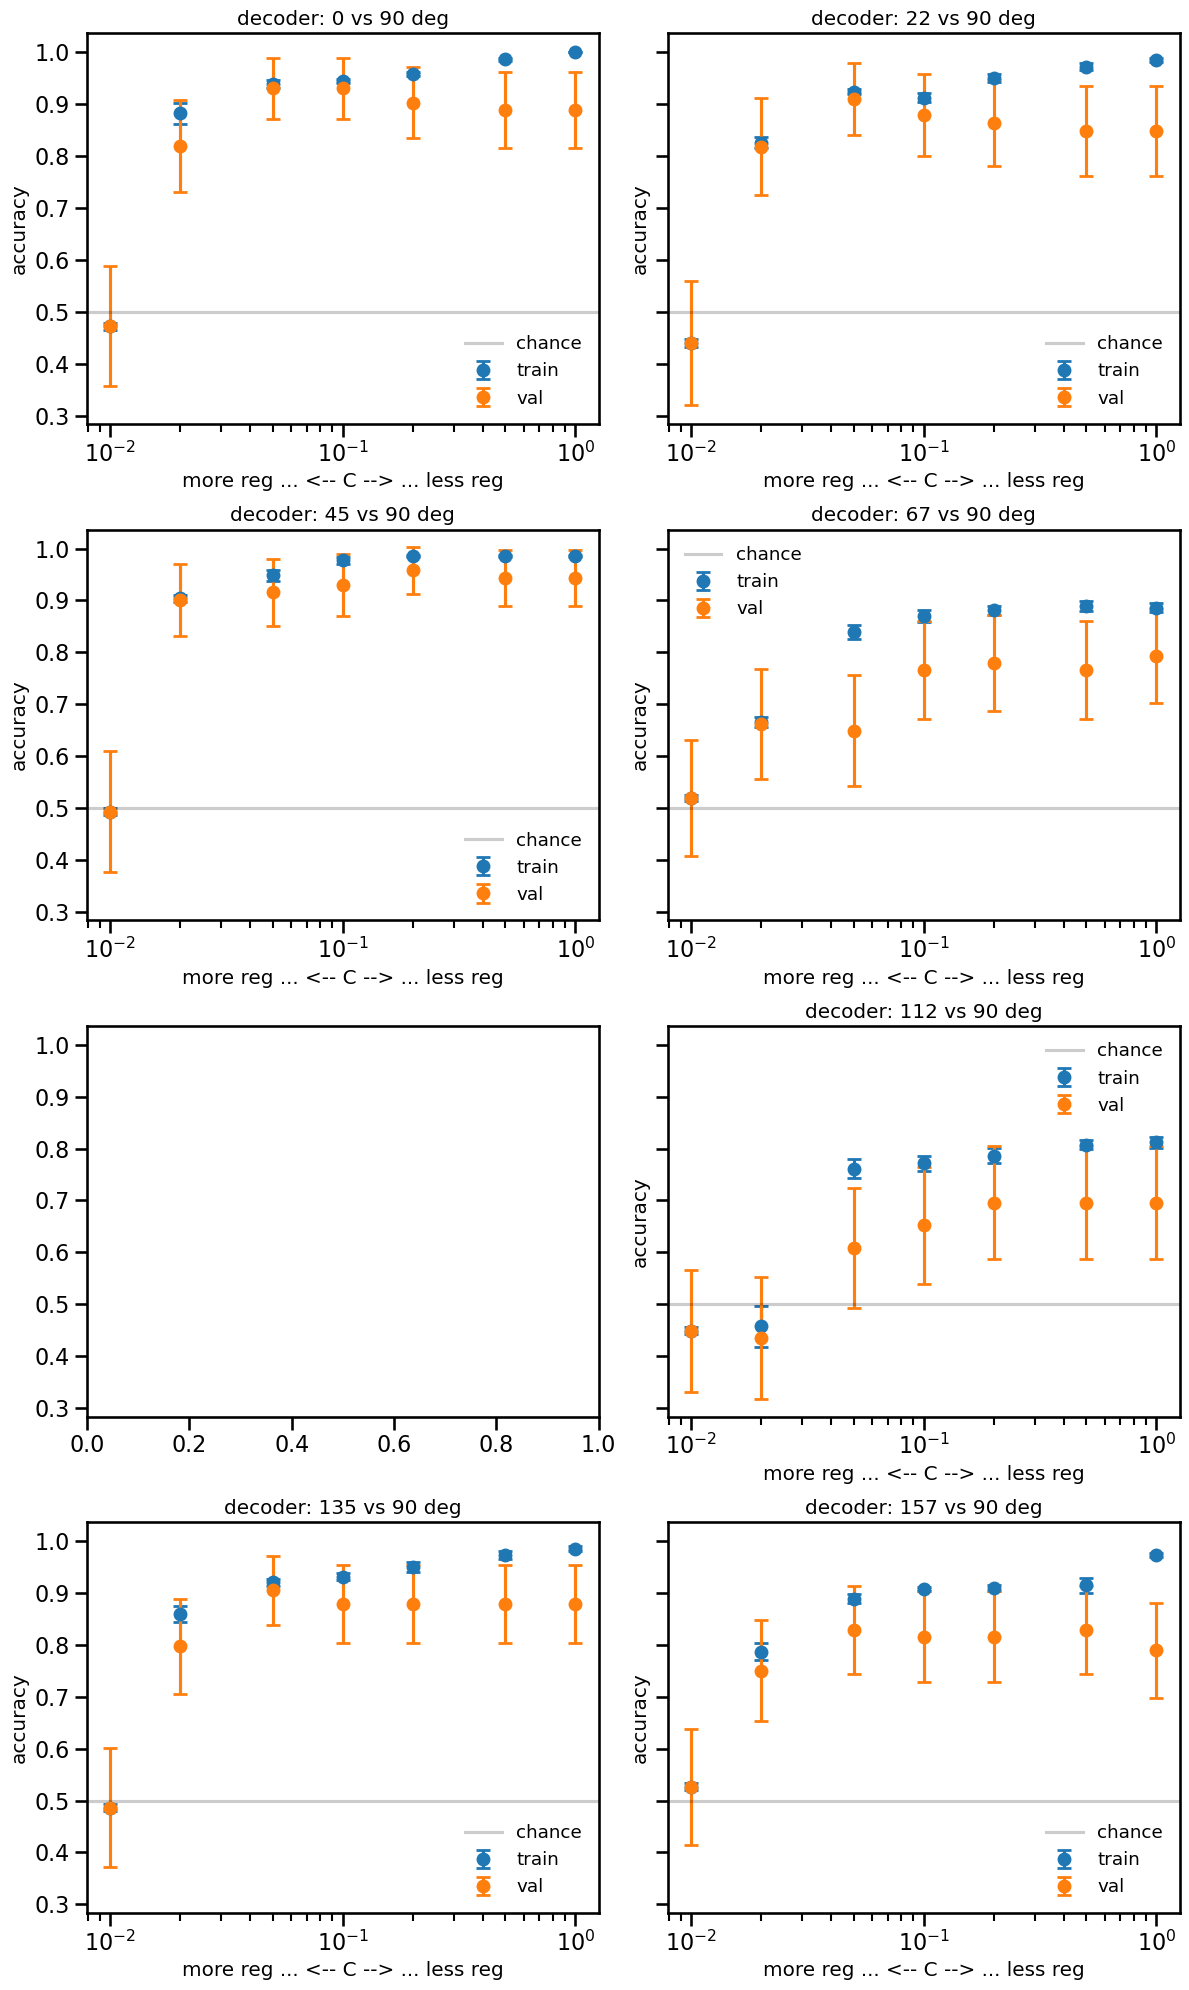

In [ ]:
## find optimal reg param C. 

nrow = 4
ncol = 2
cross_val_method = LeaveOneOut()
fig, ax = plt.subplots(4, 2, figsize=(12, 20), sharey=True)

acc_val_mean_iori = []
acc_val_ci_iori = [] # confidence interval based on binomial distribution
for iori in tqdm(other_ori):
    df_pair = df_svc[((df_svc.stim2_id == 4) | (df_svc.stim2_id == iori))]
    df_pair_250 = df_pair[df_pair.isi == 250]
    df_pair_6000 = df_pair[df_pair.isi == 6000]

    ## split train vs test for each isi
    X_train_250, X_test_250, y_train_250, y_test_250 = df_to_train_test(df_pair_250)
    X_train_6000, X_test_6000, y_train_6000, y_test_6000 = df_to_train_test(df_pair_6000)

    ## stack training data across isi - ntrial per isi mostly balanced (30% vs 35%)
    X_train = np.vstack((X_train_250, X_train_6000))
    y_train = np.hstack((y_train_250, y_train_6000))
    X_test = np.vstack((X_test_250, X_test_6000))
    y_test = np.hstack((y_test_250, y_test_6000))

    # ## shuffle trials in the same way
    # seed_val = 0
    # np.random.seed(seed_val)
    # np.random.shuffle(X_train) # shuffled along the first axis, aka trials
    # np.random.shuffle(y_train)
    # np.random.shuffle(X_test)
    # np.random.shuffle(y_test)

    ## cross validation to find optimal C
    acc_train_mean = []
    acc_train_std = []
    acc_val_mean = []
    acc_val_std = []
    acc_val_ci = [] # confidence interval based on binomial distribution
    acc_test = []
    # C_list = [1e-4 * 10**i for i in range(8)] # 1e-4, 1e-3, ..., 1e3, 1e4
    C_list = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1] # zoom in around 0.1
    nfold = 5

    use_data = 'isi_both'
    # use_data = 'isi=250' # adapted
    # use_data = 'isi=6k' # unadapted


    for C_val in C_list:
        clf = make_pipeline(StandardScaler(),
                            LinearSVC(tol=1e-5, max_iter=int(1e6), 
                                    penalty='l1', dual=False, C=C_val))
        
        if use_data == 'isi_both':
            score_val = cross_validate(clf, X_train, y_train, cv=cross_val_method, return_train_score=True) # instead of cv=nfold, use leave-one-out
        #     clf.fit(X_train, y_train)
        #     score_test = clf.score(X_test, y_test)
        # elif use_data == 'isi=250':
        #     score_val = cross_validate(clf, X_train_250, y_train_250, cv=cross_val_method, return_train_score=True)
        #     clf.fit(X_train_250, y_train_250)
        #     score_test = clf.score(X_test_250, y_test_250)
        # elif use_data == 'isi=6k':
        #     score_val = cross_validate(clf, X_train_6000, y_train_6000, cv=cross_val_method, return_train_score=True)
        #     clf.fit(X_train_6000, y_train_6000)
        #     score_test = clf.score(X_test_6000, y_test_6000)
        
        acc_train_mean.append(np.mean(score_val['train_score']))
        acc_train_std.append(np.std(score_val['train_score']))
        acc_val_mean.append(np.mean(score_val['test_score']))
        acc_val_std.append(np.std(score_val['test_score']))
        ci_low, ci_high = proportion_confint(count=score_val['test_score'].sum(), nobs=len(score_val['test_score']))
        ci_err = (ci_high - ci_low)/2
        acc_val_ci.append(ci_err)
        # acc_test.append(score_test)
    acc_val_mean_iori.append(acc_val_mean)
    acc_val_ci_iori.append(acc_val_ci)
        
        
    ax[int(iori/ncol), iori%ncol].errorbar(x=C_list, y=acc_train_mean, 
                yerr=acc_train_std, fmt='o', capsize=5, capthick=2, label='train')
    ax[int(iori/ncol), iori%ncol].errorbar(x=C_list, y=acc_val_mean,
                yerr=acc_val_ci, fmt='o', capsize=5, capthick=2, label='val')
    # ax[int(iori/ncol), iori%ncol].plot(C_list, acc_test, color='r', marker=".", alpha=0.5, label='test')
    ax[int(iori/ncol), iori%ncol].axhline(y=0.5, color='k',alpha=0.2, label='chance')

    # set x axis to log scale
    ax[int(iori/ncol), iori%ncol].set_xscale('log')

    ax[int(iori/ncol), iori%ncol].legend(frameon=False);
    ax[int(iori/ncol), iori%ncol].set_title(f'decoder: {int(22.5*iori)} vs 90 deg');
    ax[int(iori/ncol), iori%ncol].set_xlabel('more reg ... <-- C --> ... less reg');
    ax[int(iori/ncol), iori%ncol].set_ylabel('accuracy');
    
fig.tight_layout()

dir_fig = r'C:\Users\lan\Documents\repos\inter\results\decoder_grat8/'.replace('\\', '/')
fig.savefig(dir_fig + f'decoder_L1_leave1out.pdf', bbox_inches='tight')

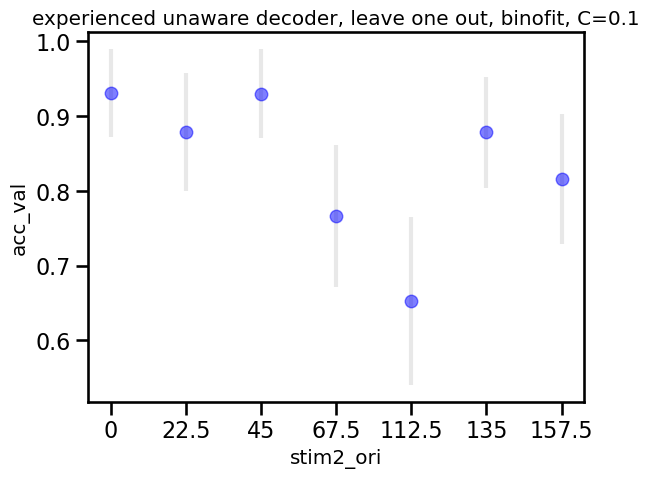

In [ ]:
fix_C = 0.1
    
acc_val_C = np.array(acc_val_mean_iori)[:, np.where(np.array(C_list)==fix_C)[0][0]]
acc_val_ci_C = np.array(acc_val_ci_iori)[:, np.where(np.array(C_list)==fix_C)[0][0]]

plt.errorbar(x=np.arange(len(stim2_ori_list)), 
             y=acc_val_C, 
             yerr=acc_val_ci_C, 
             fmt='o', color='b', alpha=0.5, ecolor='lightgray', elinewidth=3, capsize=0);

stim2_ori_list = ['0', '22.5', '45', '67.5', '112.5', '135', '157.5']
plt.xticks(np.arange(len(stim2_ori_list)), stim2_ori_list);
plt.xlabel('stim2_ori')
plt.ylabel(f'acc_val');

title_str = f'experienced unaware decoder, leave one out, binofit, C={fix_C}'
plt.title(title_str);
plt.savefig(dir_fig + f'{title_str}.pdf', bbox_inches='tight')

# expand
area subplot, isi color, date_sess errorbar  
fix C=0.1

In [ ]:
iarea = 'LI'

true_pos_isi = []
n_sample_isi = []
for use_data in ['isi=250', 'isi=6k']:

    true_pos_ori = np.zeros(len(other_ori) + 1) # true positive across ori pairs. leave a blank for stim2_id=4 (90 deg)
    n_sample_ori = np.zeros(len(other_ori) + 1)

    nsess_iarea = (df_tidy[(df_tidy.area == iarea) 
                           & (df_tidy.filter_cell_vis == True)] # some LI sessions have no vis cell
                .groupby(['date', 'sess'])
                .first().__len__())

    for isess in tqdm(range(nsess_iarea)):
        del df_svc
        df_svc = get_df_svc(df_tidy, iarea=iarea, idatesess=isess, ncell_keep=999)

        for iori in (other_ori):
            
            df_pair = df_svc[((df_svc.stim2_id == 4) | (df_svc.stim2_id == iori))]
            df_pair_250 = df_pair[df_pair.isi == 250]
            df_pair_6000 = df_pair[df_pair.isi == 6000]

            X_train_250, X_test_250, y_train_250, y_test_250 = df_to_train_test(df_pair_250)
            X_train_6000, X_test_6000, y_train_6000, y_test_6000 = df_to_train_test(df_pair_6000)


            clf = make_pipeline(StandardScaler(),
                                LinearSVC(tol=1e-5, max_iter=int(1e6), 
                                        penalty='l1', dual=False, C=0.1))

            if use_data == 'isi=250':
                score_val = cross_validate(clf, X_train_250, y_train_250, cv=LeaveOneOut(), return_train_score=True)
            elif use_data == 'isi=6k':
                score_val = cross_validate(clf, X_train_6000, y_train_6000, cv=LeaveOneOut(), return_train_score=True)

            true_pos = score_val['test_score'].sum()
            n_sample = len(score_val['test_score'])
            true_pos_ori[iori] += true_pos
            n_sample_ori[iori] += n_sample
    
    true_pos_isi.append(true_pos_ori)
    n_sample_isi.append(n_sample_ori)

100%|██████████| 15/15 [01:02<00:00,  4.18s/it]


In [ ]:
# decode_res_V1 = [true_pos_isi, n_sample_isi]
# decode_res_LM = [true_pos_isi, n_sample_isi]
# decode_res_LI = [true_pos_isi, n_sample_isi]

# grat8_decode_all_cells = {'decode_res_V1': decode_res_V1,
#                     'decode_res_LM': decode_res_LM,
#                     'decode_res_LI': decode_res_LI}
# import pickle
# with open(dir_fig + 'grat8_decode_all_cells.pickle', 'wb') as f:
#     pickle.dump(grat8_decode_all_cells, f)


# iarea = 'LM'
# true_pos_isi, n_sample_isi = decode_res_LM

## plot

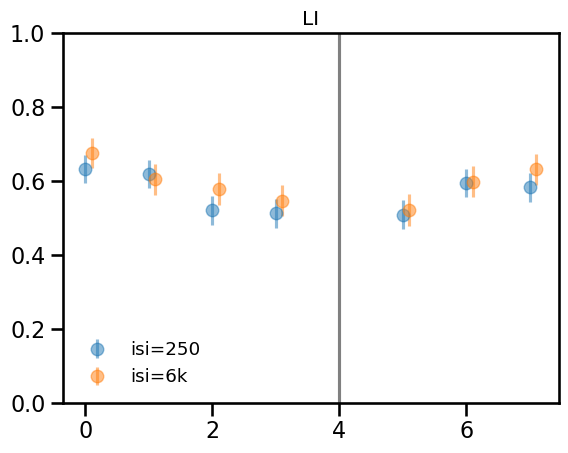

In [ ]:
# suppress RuntimeWarning: invalid value encountered in true_divide
import warnings
warnings.filterwarnings('ignore')

isi_list = ['isi=250', 'isi=6k']
nisi = len(isi_list)
for iisi in range(nisi):

    ci_low, ci_high = proportion_confint(count=true_pos_isi[iisi], 
                                         nobs=n_sample_isi[iisi])
    ci_err = (ci_high - ci_low)/2
    
    plt.errorbar(x=np.arange(8) + iisi*0.1, 
                y=true_pos_isi[iisi] / n_sample_isi[iisi], 
                yerr=ci_err, 
                label=isi_list[iisi], fmt='o', alpha=0.5);

plt.axvline(x=4, color='gray', linestyle='-');
plt.ylim(0, 1);
plt.legend(frameon=False, loc='lower left');
plt.title(iarea);